<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: Deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы.
* Рекуррентными и сверточными классификаторами аудиоданных.
* Алгоритмом аугментации аудиоданных SpecAugment.

In [ ]:
!pip install torch==1.8.1 torchaudio==0.8.0 numpy==1.20.0

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio

import pandas as pd

assert torch.__version__.startswith('1.8.1')
assert torchaudio.__version__ == '0.8.0'

device='cuda:0'

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/file/d/12emmtpodmo1783e6VOOEjV20zAKl5dZR/view?usp=sharing) c и распакуйте в папку `./data`.

2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.


In [ ]:
# скачаем и распакуем данные
!rm -r ./data
!mkdir ./data/

rm: cannot remove './data': No such file or directory


In [ ]:
!pip install gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd ./data && gdown https://drive.google.com/uc?id=12emmtpodmo1783e6VOOEjV20zAKl5dZR && unzip /content/drive/MyDrive/hw2/HW2_dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: ur

In [ ]:
# классы данных
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
           'siren', 'street_music']

In [ ]:
pd.read_csv('/content/data/urbansound8k/train_part.csv')

,ID,Class
0,7131,air_conditioner
1,5658,siren
2,570,drilling
3,57,drilling
4,5253,drilling
...,...,...
4495,1357,jackhammer
4496,2902,engine_idling
4497,223,children_playing
4498,6537,drilling


In [ ]:
import os

import pandas as pd
import numpy as np


class AudioDataset(Dataset):
    def __init__(self, path_to_csv: str, 
                 path_to_folder: str, 
                 pad_size: int=384000,
                 sr: int = 44100):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[['ID', 'Class']]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        id = self.csv['ID'][index]
        class_ = self.class_to_idx[self.csv['Class'][index]]
        path = f'{self.path_to_folder}/{id}.wav'
        wav, sr = torchaudio.load(path)

        if sr != self.sr:
            resampler = torchaudio.transforms.Resample(sr, self.sr)
            wav = resampler(wav)

        wav = wav.squeeze()
        item = torch.zeros(self.pad_size)
        item[:len(wav)] = wav
        return {'x':item,
                'y':class_,
                'len': len(wav)}

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
# создадим датасеты
train_dataset = AudioDataset('./data/urbansound8k/train_part.csv', './data/urbansound8k/data')
val_dataset = AudioDataset('./data/urbansound8k/val_part.csv', './data/urbansound8k/data')

In [ ]:
PAD_SIZE = train_dataset.pad_size

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item['x'].shape == (384000, )
assert item['y'] == 0
assert item['len'] == 176400

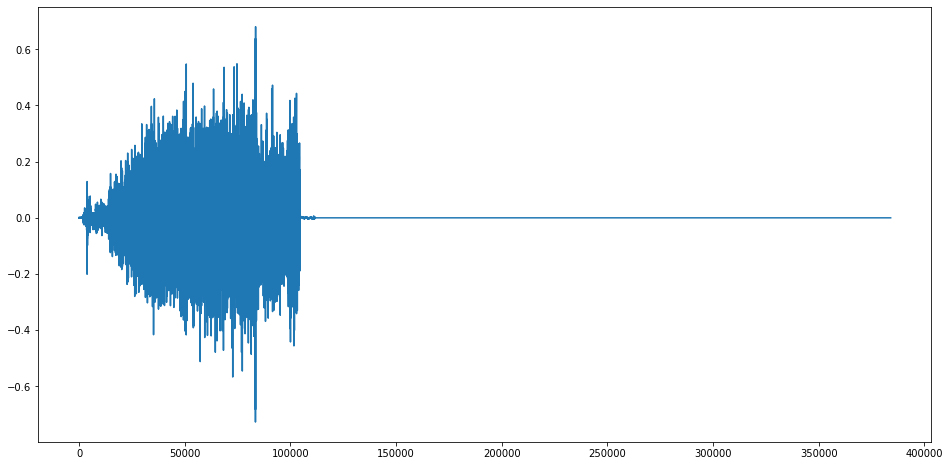

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(2)
plt.figure(figsize=(16, 8))
plt.plot(item['x'])

display.Audio(item['x'], rate=train_dataset.sr)

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(train_dataset, 32, shuffle=True,
                              pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32,
                            pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](./imgs/rnn_raw.png)

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [ ]:
class RecurrentRawAudioClassifier(nn.Module):
  def __init__(self, 
               num_classes=10,
               window_length=1024,
               hop_length=256,
               hidden=256,
               num_layers=2):
    super().__init__()

    self.window_length = window_length
    self.hop_length = hop_length

    ### YOUR CODE IS HERE ######
    self.first_mlp = nn.Sequential(nn.Linear(self.window_length, 256),
                                   nn.BatchNorm1d(int((PAD_SIZE-window_length)/hop_length + 1)),
                                   nn.ReLU(),
                                   nn.Linear(256, 64),
                                   nn.BatchNorm1d(int((PAD_SIZE-window_length)/hop_length + 1)),
                                   nn.ReLU(),
                                   nn.Linear(64, 16))
                                   
                                   

    self.rnn = nn.LSTM(16, hidden, 2, bidirectional=True, batch_first=True)

    self.final_mlp = nn.Sequential(nn.Linear(hidden*2*num_layers, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(),
                                   nn.Linear(256, 10),
                                   nn.Softmax(dim=1)
                                   )
    ### THE END OF YOUR CODE ###

  def forward(self, x, lens):
    # разбейте сигнал на окна 
    # batch_windows.shape == (B, NUM WINDOWS, 1024)
    batch_windows = x.unfold(1, self.window_length, self.hop_length)  #your code here


    # примените к каждому окну полносвязную сеть
    # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
    batch_windows_feautures = self.first_mlp(batch_windows)#your code here

    # примените к получившемся последовательностям LSTM и возьмите hidden state
    out, (h_n, c_n) = self.rnn(batch_windows_feautures)

    # склейте hidden_state по слоям
    # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
    hidden_flattened = torch.cat(tuple(h_n), axis=1) #your code here

    # примените полносвязную сеть и получим логиты классов
    return self.final_mlp(hidden_flattened) #your code here

Обучим получившуюся модель.

In [ ]:
from IPython.display import clear_output

def train_audio_clfr(model, optimizer, train_dataloader, sr,
                     criterion=torch.nn.CrossEntropyLoss(),
                     data_transform=None, 
                     augmentation=None,
                     num_epochs=10, device='cuda:0',
                     verbose_num_iters=10):
  model.train()
  iter_i = 0

  train_losses = []
  train_accuracies = []

  for epoch in range(num_epochs):  
    for batch in train_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        # применяем преобразование входных данных
        if data_transform:
          x, lens = data_transform(x,
                                   lens, 
                                   device=device, 
                                   sr=sr)

        # примеменяем к логмелспектрограмме аугментацию
        if augmentation:
          x, lens = augmentation(x, lens)

        # делаем предсказания
        probs = model(x, lens)

        # делаем шаг градиента
        optimizer.zero_grad()
        loss = criterion(probs, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        # считаем точность предсказания
        pred_cls = probs.argmax(dim=-1)
        train_accuracies.append((pred_cls == y).float().mean().item())
    
        iter_i += 1

        # раз в verbose_num_iters визуализируем наши лоссы и семплы
        if iter_i % verbose_num_iters == 0:
            clear_output(wait=True)

            print(f'Epoch {epoch}')

            plt.figure(figsize=(10, 5))
                
            plt.subplot(1, 2, 1)
            plt.xlabel('Iteration')
            plt.ylabel('Train loss')
            plt.plot(np.arange(iter_i), train_losses)

            plt.subplot(1, 2, 2)
            plt.xlabel('Iteration')
            plt.ylabel('Train acc')
            plt.plot(np.arange(iter_i), train_accuracies)

            plt.show()

  model.eval()

In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device);

optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


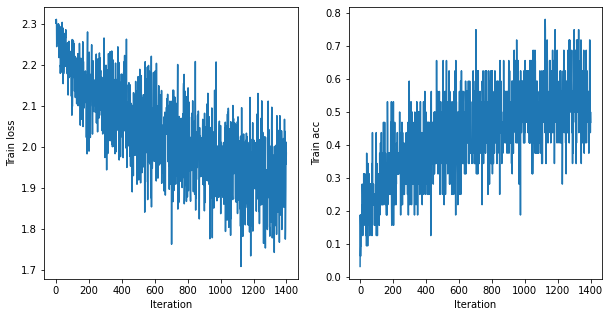

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
  pred_true_pairs = []
  for batch in val_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        with torch.no_grad():
          if data_transform:
            x, lens = data_transform(x, lens, sr=sr, device=device)

          probs = model(x, lens)

          pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
          pred_true_pairs.append((pred, true))

  print(f'Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}')

  cm_df = pd.DataFrame(
      confusion_matrix([p[1] for p in pred_true_pairs], 
                       [p[0] for p in pred_true_pairs], 
                       normalize='true'),
      columns=classes, index=classes)
  sn.heatmap(cm_df, annot=True)

Val accuracy: 0.360427807486631


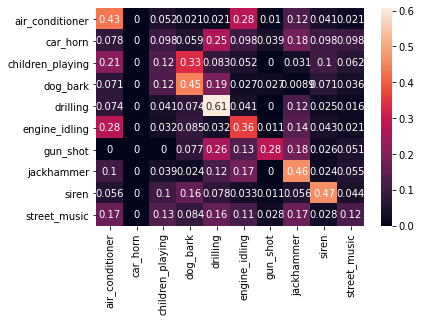

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

На тренировочной выборке accuracy колебалась около 0.5 на последних эпохах, на валидационной выборке accuracy равно 0.37. Модель переобучается, скорее всего звуки в тренировочной и тестовой выборке различаются и она не находит паттерны одинаковые для разных звуков из одного класса. Также может влиять использование волн как признаков, так как они не очень стабильные и незначительные различия в звуке, которые не обусловлены его классом, приводят к значительным различиям в объектах тренировочной и валидационной выборки.

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [ ]:
from torchaudio.transforms import MelSpectrogram

# референсная функця
def compute_log_melspectrogram_reference(wav_batch, 
                                         lens,
                                         sr,
                                         device='cpu'):
  featurizer = MelSpectrogram(
      sample_rate=sr,
      n_fft=1024,
      win_length=1024,
      hop_length=256,
      n_mels=64,
      center=False,
      ).to(device)

  return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

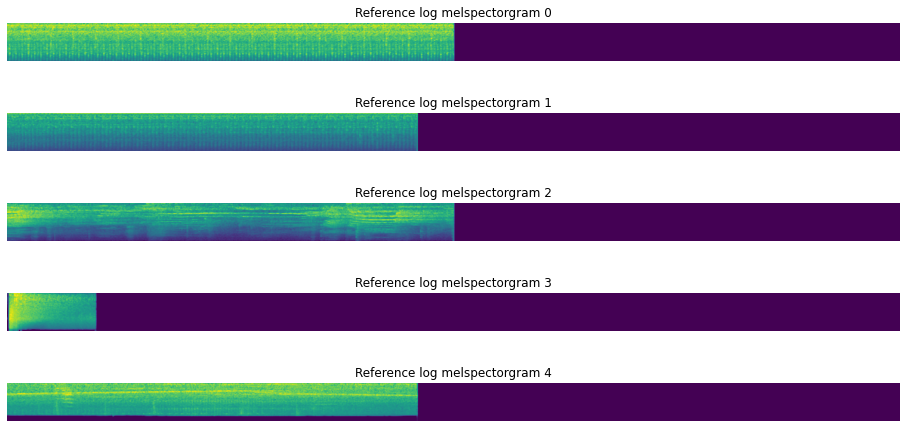

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
  break
wav_batch = batch['x']
lens = batch['len']

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Reference log melspectorgram {i}')
  axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [ ]:
sr = train_dataset.sr
n_fft=1024
win_length=1024
hop_length=256
n_mels=64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [ ]:
windows = wav_batch.unfold(1, win_length, hop_length) # your code here
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

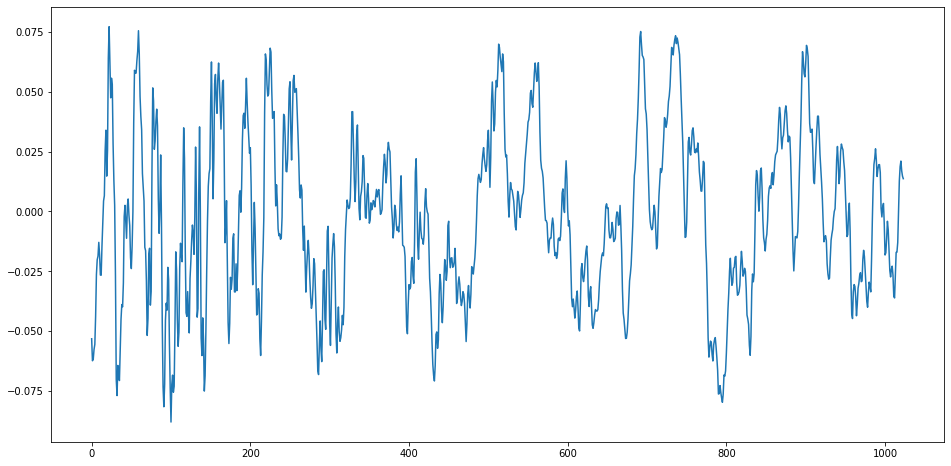

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(1024) # your code here
windows_with_applied_filter = windows * filter[None, None, :]

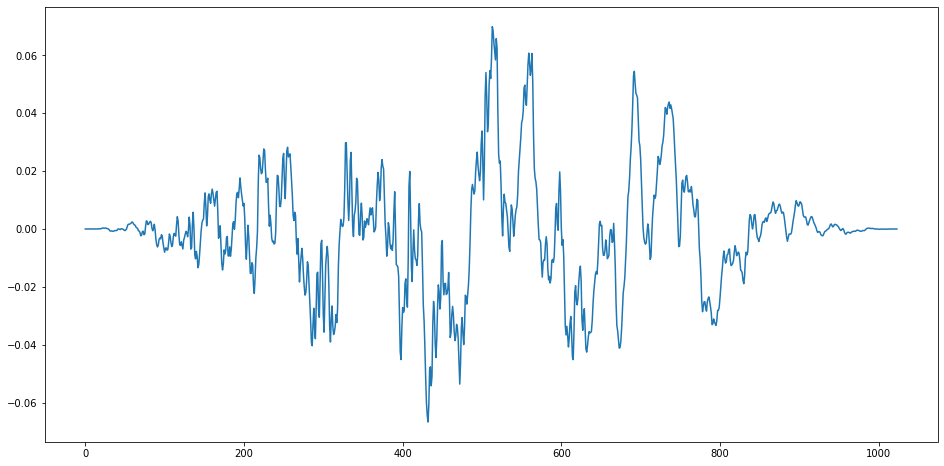

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:,:,:n_fft//2 +1] # your code here
fft_magnitudes = torch.abs(fft_features ** 2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [ ]:
melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft= n_fft//2 +1) # your code here

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

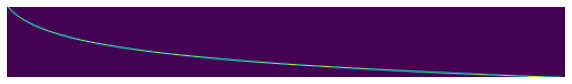

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [ ]:
mel_spectrogram = melscale(fft_magnitudes.permute(0, 2, 1)) # your code here
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5)) # your code here
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

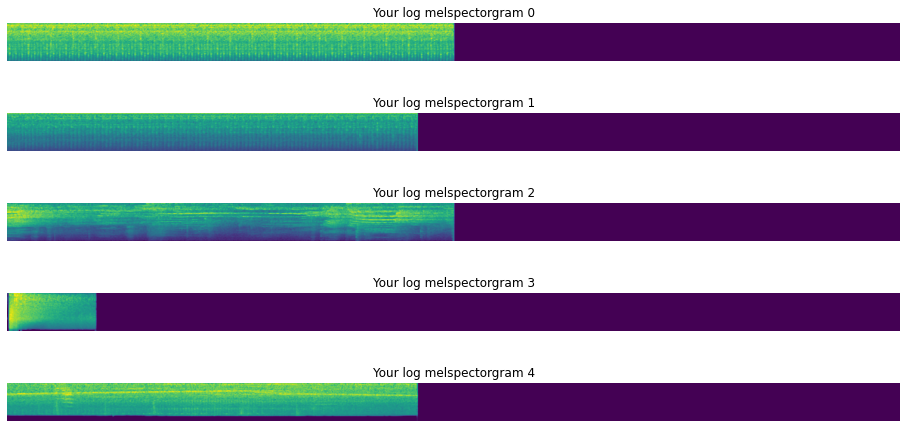

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Your log melspectorgram {i}')
  axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [ ]:
# ваша реализация
def compute_log_melspectrogram(wav_batch,
                               lens,
                               sr,
                               device='cpu'):
  ### YOUR CODE IS HERE ######
    windows = wav_batch.unfold(1, 1024, 256)
    filter = torch.hann_window(1024, device=device) 
    windows_with_applied_filter = windows * filter[None, None, :]
    fft_features = torch.fft.fft(windows_with_applied_filter)[:,:,:1024//2 +1]
    fft_magnitudes = torch.abs(fft_features ** 2)
    melscale = torchaudio.transforms.MelScale(n_mels=64, sample_rate=sr, n_stft= 1024//2 +1)
    melscale.fb = melscale.fb.to(device)
    mel_spectrogram = melscale(fft_magnitudes.permute(0, 2, 1))
    logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
    return logmel_spectrogram, torch.floor((lens-1024)/256 + 1).long()
  ### THE END OF YOUR CODE ###

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

![arch_mel](./imgs/rnn_mel.png)

**За реализацию архитектуры дается 0.5 балла.**

In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
  def __init__(self, 
               num_classes=10,
               window_length=1024,
               hop_length=256,
               hidden=256,
               num_layers=2):
    super().__init__()

    self.window_length = window_length
    self.hop_length = hop_length

    ### YOUR CODE IS HERE ######
    self.rnn = nn.LSTM(64, hidden, 2, bidirectional=True, batch_first=True)

    self.final_mlp = nn.Sequential(nn.Linear(hidden*2*num_layers, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(),
                                   nn.Linear(256, 10),
                                   nn.Softmax(dim=1)
                                   )
    ### THE END OF YOUR CODE ###

  def forward(self, x, lens):
   ### YOUR CODE IS HERE ###### 
    out, (h_n, c_n) = self.rnn(x.permute(0, 2, 1))
    flattened = torch.cat(tuple(h_n), axis=1)
    return self.final_mlp(flattened)   
   ### THE END OF YOUR CODE ###

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device);

optim = torch.optim.AdamW(rnn_mel.parameters(), lr=1e-4)


Epoch 19


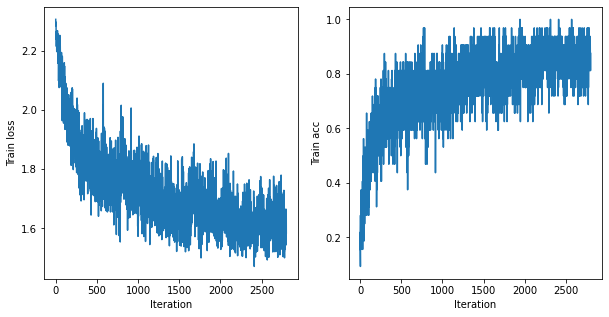

In [ ]:
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.6941176470588235


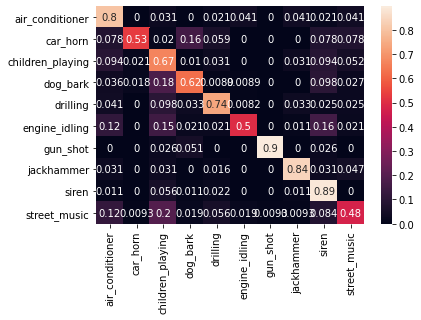

In [ ]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [ ]:
class CNN10(nn.Module):
  def __init__(self, num_classes=10, hidden=16):
    super().__init__()

    ### YOUR CODE IS HERE ######
    self.cnn_backbone = nn.Sequential(nn.Conv2d(1, 16, 3),
                                      nn.BatchNorm2d(16),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 16, 3),
                                      nn.BatchNorm2d(16),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(16, 32, 3),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                      nn.Conv2d(32, 32, 3),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(32, 64, 3),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.Conv2d(64, 64, 3),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(64, 128, 3),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 128, 2),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU())

    self.final_mlp = nn.Sequential(nn.Linear(128, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 10),
                                   nn.Softmax(dim=1))
    ### THE END OF YOUR CODE ###

  def forward(self, x, lens):
    z = self.cnn_backbone(x[:, None, :, :])
    z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
    return self.final_mlp(z)

In [ ]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.AdamW(cnn.parameters(), lr=1e-4)

Epoch 19


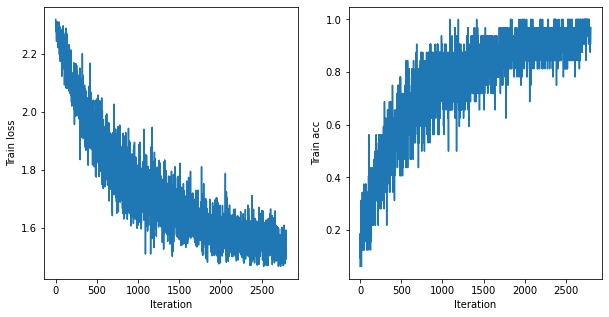

In [ ]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9080213903743316


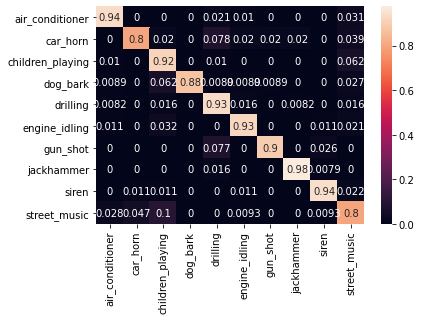

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

Добавил weight_decay 1e-2 для получения нужного качества

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [ ]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value = 'mean',
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 10,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        ### YOUR CODE IS HERE ######
        if self.filling_value == 'mean':
            v = (spect * (spect > spect.min())).mean(axis=2).mean(axis=1).unsqueeze(1).unsqueeze(1)

        elif self.filling_value == 'min':
            v = (spect * (spect > spect.min())).min(axis=2)[0].min(axis=1)[0].unsqueeze(1).unsqueeze(1)
        
        elif self.filling_value == 'max':
            v = (spect * (spect > spect.max())).mean(axis=2).max(axis=1).unsqueeze(1).unsqueeze(1)

        else:
            v = torch.full(size=(32,1,1), fill_value=self.filling_value, device=spect.device)

        mask_freq = torch.zeros_like(spect, device=spect.device, dtype=spect.dtype)
        mask_time = torch.zeros_like(spect, device=spect.device, dtype=spect.dtype)
      

        first_freq = torch.round(-62*torch.rand(self.n_freq_masks, 32, device=spect.device) + 62).long()
        right_freq = (first_freq + torch.randint(low=1, high=11, size=(self.n_freq_masks, 32), device=spect.device)).clip(max=63)

        first_time = torch.round(-(lens-1)*torch.rand(self.n_time_masks, 32, device=spect.device) + (lens-1)).long() 
        right_time = (first_time + torch.randint(low=1, high=51, size=(self.n_time_masks, 32), device=spect.device)).clip(max=1496)

        mask_freq[torch.arange(0,32, device=spect.device),first_freq,:] = 1
        mask_freq[torch.arange(0,32, device=spect.device),right_freq,:] = -1

        mask_time[torch.arange(0,32, device=spect.device),:,first_time] = 1
        mask_time[torch.arange(0,32, device=spect.device),:,right_time] = -1

        return (((mask_freq.cumsum(axis=1) > 0) | (mask_time.cumsum(axis=2) > 0)) &
                (spect > spect.min())) * v + (((mask_freq.cumsum(axis=1) == 0) & (mask_time.cumsum(axis=2) == 0)) | 
                (spect == spect.min())) * spect, lens

        ### THE END OF YOUR CODE ###

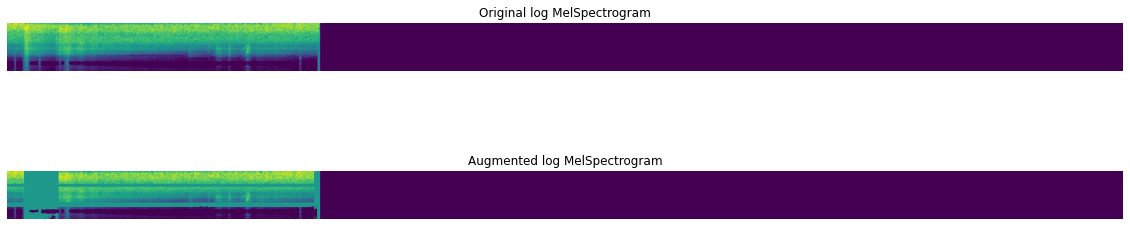

In [ ]:
# применим аугментацию к данным
for batch in train_dataloader:
  break

x = batch['x'].to(device)
lens = batch['len'].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title('Original log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title('Augmented log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel_augmented[0].cpu().numpy())

In [ ]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=1e-4)

Epoch 29


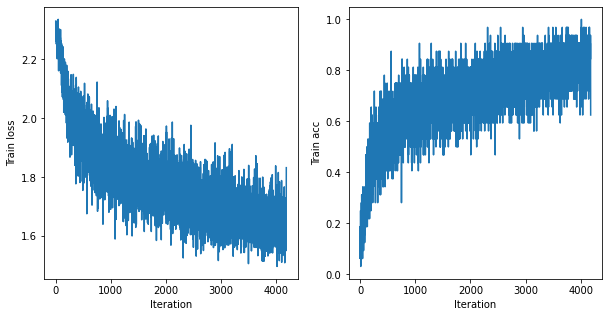

KeyboardInterrupt: ignored

In [ ]:
# обучим модель на данных с аугментациями
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(n_time_masks=2, n_freq_masks=1, max_time=5, max_freq=5),
                 num_epochs=30)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.825668449197861


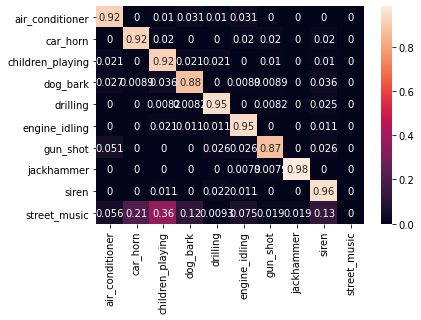

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)